In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
import gc  # Garbage collector for memory cleanup
import os
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import glob
from PIL import Image
matplotlib.style.use('ggplot')

In [2]:
!mkdir input

mkdir: cannot create directory ‘input’: File exists


In [3]:
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/GAN_outputs"
os.makedirs(output_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# learning parameters
batch_size = 128
epochs = 300
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

to_pil_image = transforms.ToPILImage()

In [6]:
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#save ram
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [7]:
torch.cuda.empty_cache()
gc.collect()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

# Labels
def label_real(size):
    return torch.ones(size, 1, device=device)

def label_fake(size):
    return torch.zeros(size, 1, device=device)

# Create noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, device=device)

# Save images
def save_generator_image(image, path):
    save_image(image, path)

# Train Discriminator
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# Train Generator
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss

# Checkpoint path
checkpoint_path = f"{output_dir}/generator_checkpoint.pth"

# Load checkpoint if it exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    generator.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
 #   generator.load_state_dict(torch.load(checkpoint_path))
    start_epoch = 241  # Resume from epoch 270
    print(f"✅ Resuming training from epoch {start_epoch}")

# Create noise vector
noise = create_noise(sample_size, nz)

# Training Loop
generator.train()
discriminator.train()

losses_g, losses_d, images = [], [], []

# Load existing loss file if available (resuming from checkpoint)
loss_csv_path = f"{output_dir}/losses.csv"
if os.path.exists(loss_csv_path):
    loss_df = pd.read_csv(loss_csv_path)
    losses_g = loss_df["generator_loss"].tolist()
    losses_d = loss_df["discriminator_loss"].tolist()
    start_epoch = len(losses_g)  # Resume from the last saved epoch
    print(f"✅ Resuming training from epoch {start_epoch}")
else:
    losses_g, losses_d = [], []  # Start fresh if no saved loss file

for epoch in range(start_epoch, epochs):
    loss_g, loss_d = 0.0, 0.0
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # Train Discriminator
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            loss_d += train_discriminator(optim_d, image, data_fake)

        # Train Generator
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)

    # Generate sample image (only save every 10 epochs)
    if epoch % 10 == 0:
        with torch.no_grad():
            generated_img = generator(noise).cpu()
        generated_img = make_grid(generated_img, normalize=True)
        save_generator_image(generated_img, f"{output_dir}/gen_img{epoch}.png")
        images.append(generated_img)

        # ✅ Display generated image
        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(generated_img.numpy(), (1, 2, 0)))  # Convert tensor to numpy format for plotting
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

    # Compute average loss for the epoch
    epoch_loss_g = loss_g / len(train_loader)
    epoch_loss_d = loss_d / len(train_loader)
    losses_g.append(epoch_loss_g.cpu().item())
    losses_d.append(epoch_loss_d.cpu().item())

    print(f"Epoch {epoch} of {epochs} | Generator loss: {epoch_loss_g:.8f} | Discriminator loss: {epoch_loss_d:.8f}")

    # ✅ Save updated loss values after every epoch
    loss_df = pd.DataFrame({
        "epoch": list(range(len(losses_g))),
        "generator_loss": losses_g,
        "discriminator_loss": losses_d
    })
    loss_df.to_csv(loss_csv_path, index=False)

    print("✅ Loss values saved!")

    # Save model checkpoint every 30 epochs
    if epoch % 30 == 0:
        torch.save(generator.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch}")

    # Free memory
    torch.cuda.empty_cache()
    gc.collect()

print("🎉 Training Completed!")

# Final Model Save
torch.save(generator.state_dict(), f"{output_dir}/generator_final.pth")



Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Get all saved images from the directory (sorted by epoch number)
image_files = sorted(glob.glob(f"{output_dir}/gen_img*.png"))

# Load images into a list
imgs = [np.array(Image.open(img_file)) for img_file in image_files]

# Create and save the GIF
imageio.mimsave(f"{output_dir}/generator_images.gif", imgs, duration=5)  # Adjust duration for speed

print(f"🎉 GIF created with {len(imgs)} images!")

🎉 GIF created with 30 images!


✅ Loss data loaded successfully!
🎉 Loss plot regenerated!


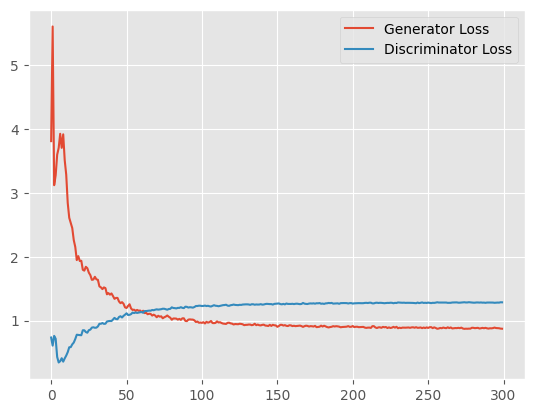

In [10]:
loss_csv_path = f"{output_dir}/losses.csv"

if os.path.exists(loss_csv_path):
    loss_df = pd.read_csv(loss_csv_path)
    losses_g = loss_df["generator_loss"].tolist()
    losses_d = loss_df["discriminator_loss"].tolist()
    print("✅ Loss data loaded successfully!")

    # Recreate and save loss plot
    plt.figure()
    plt.plot(losses_g, label="Generator Loss")
    plt.plot(losses_d, label="Discriminator Loss")
    plt.legend()
    plt.savefig(f"{output_dir}/loss.png")
    print("🎉 Loss plot regenerated!")
else:
    print("⚠️ Loss file not found. Cannot regenerate the plot.")